In [1]:
#calculate mIoU, per class IoU, and Dice for each image
#record results
#merge results with other info (lat, lon, storm, date, etc.)

In [2]:
#load up the basics
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#import TF stuff
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.9.1
 GPU: /device:GPU:0


In [3]:
#Load in DF
doodlecsvpath = '../data/DoodleTestingManifestOct28_22.csv'
doodlecsv = pd.read_csv(doodlecsvpath)
doodlecsv.head()

,doodled_image,imageP,image,Filename,storm_id,archive,Latitude,Longitude,is_unique,doodled_only_once
0,S21775624-0_L1.jpg,S21775624-0.jpg,S21775624.jpg,Isaias/20200804a_jpgs/jpgs/S21775624.jpg,isaias,20200804a_jpgs,32.914668,-79.574800,True,True
1,S21767442-2_L1.jpg,S21767442-2.jpg,S21767442.jpg,Isaias/20200804a_jpgs/jpgs/S21767442.jpg,isaias,20200804a_jpgs,34.661264,-76.496155,True,True
2,P19747944-0_L1.jpg,P19747944-0.jpg,P19747944.jpg,Barry/20190716a_jpgs/jpgs/P19747944.jpg,barry,20190716a_jpgs,29.729276,-93.013003,True,True
3,S28474304-0_L1.jpg,S28474304-0.jpg,S28474304.jpg,Michael/20181011a_jpgs/jpgs/S28474304.jpg,michael,20181011a_jpgs,30.240322,-87.720852,True,True
4,P26056634-0_L1.jpg,P26056634-0.jpg,P26056634.jpg,Florence/20180917a_jpgs/jpgs/P26056634.jpg,florence,20180917a_jpgs,34.553545,-77.294043,True,True


In [4]:
#make paths for images and labels in pandas df

doodlecsv['doodled_image_path'] = '../data/testing/images/' + doodlecsv['doodled_image']
doodlecsv['doodled_label_path'] = '../data/testing/labels/' + doodlecsv['doodled_image']
doodlecsv["doodled_label_path"] = doodlecsv["doodled_label_path"].str.replace(".jpg","_label.jpg")

doodlecsv.head()

,doodled_image,imageP,image,Filename,storm_id,archive,Latitude,Longitude,is_unique,doodled_only_once,doodled_image_path,doodled_label_path
0,S21775624-0_L1.jpg,S21775624-0.jpg,S21775624.jpg,Isaias/20200804a_jpgs/jpgs/S21775624.jpg,isaias,20200804a_jpgs,32.914668,-79.574800,True,True,../data/testing/images/S21775624-0_L1.jpg,../data/testing/labels/S21775624-0_L1_label.jpg
1,S21767442-2_L1.jpg,S21767442-2.jpg,S21767442.jpg,Isaias/20200804a_jpgs/jpgs/S21767442.jpg,isaias,20200804a_jpgs,34.661264,-76.496155,True,True,../data/testing/images/S21767442-2_L1.jpg,../data/testing/labels/S21767442-2_L1_label.jpg
2,P19747944-0_L1.jpg,P19747944-0.jpg,P19747944.jpg,Barry/20190716a_jpgs/jpgs/P19747944.jpg,barry,20190716a_jpgs,29.729276,-93.013003,True,True,../data/testing/images/P19747944-0_L1.jpg,../data/testing/labels/P19747944-0_L1_label.jpg
3,S28474304-0_L1.jpg,S28474304-0.jpg,S28474304.jpg,Michael/20181011a_jpgs/jpgs/S28474304.jpg,michael,20181011a_jpgs,30.240322,-87.720852,True,True,../data/testing/images/S28474304-0_L1.jpg,../data/testing/labels/S28474304-0_L1_label.jpg
4,P26056634-0_L1.jpg,P26056634-0.jpg,P26056634.jpg,Florence/20180917a_jpgs/jpgs/P26056634.jpg,florence,20180917a_jpgs,34.553545,-77.294043,True,True,../data/testing/images/P26056634-0_L1.jpg,../data/testing/labels/P26056634-0_L1_label.jpg


In [5]:
#Load up the TF model

#model path
model_path = './model/NOAA_NewLoss_fullmodel_model'

# load model into tf
model = tf.keras.models.load_model(model_path, compile = True)


In [6]:
# standardization using adjusted standard deviation, as required by Gym model

def standardize(img):

    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0 / np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    del m, s, N
    #
    if np.ndim(img) == 2:
        img = np.dstack((img, img, img))

    return img

#this is a fn to make sure the doodler-derived labels go from 0- (num_classes-1)

num_classes = 4

def D_Filter(image):
    image[image>(num_classes-1)] = (num_classes-1)
    return image


In [7]:
#here i am loading in the custom loss and metrics

#define new Dice coeff
def E_dice_coef(y_true, y_pred):
    smooth = 10e-6
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice

#define new multi-dice workflow
def E_dice_multi_metric(nclasses):
    
    def dice_coef(y_true, y_pred):
        dice = 0
        #can't have an argmax in a loss
        #y_pred = tf.one_hot(tf.argmax(y_pred, -1), 4)
        for index in range(nclasses):
            dice += E_dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        return dice/nclasses
    
    return dice_coef

#define the loss, which calls the metrics
def E_dice_coef_loss(nclasses):
    
    def E_dice_MC_coef_loss(y_true, y_pred):
        dice = 0
        #can't have an argmax in a loss
        #y_pred = tf.one_hot(tf.argmax(y_pred, -1), 4)
        for index in range(nclasses):
            dice += E_dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        return 1 - (dice/nclasses)
    
    return E_dice_MC_coef_loss


In [8]:
#compile the model
model.compile(optimizer = 'adam', 
              loss =E_dice_coef_loss(num_classes), 
              metrics = [E_dice_multi_metric(num_classes), 
                         tf.keras.metrics.OneHotMeanIoU(num_classes=num_classes),
                         tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=[0]),
                         tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=[1]),
                         tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=[2]),
                         tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=[3])]
             )

In [9]:
#run model for each row of dataframe, and put results in correct column

#Evaluate on all images:
# 1. loop over all rows in data frame
# 2. grab image path
# 3. evaluate image w/ TFLite
# 4. write output to df
# 5. make plot

# fn to do tflite prediction
def TFPred (ImPath,LaPath):
    imsize = (768,1024)
    #SET THE IMAGE
    TestIm = tf.keras.preprocessing.image.load_img(ImPath,target_size = imsize)
    TestIm = tf.keras.preprocessing.image.img_to_array(TestIm)
    TestIm = standardize(TestIm)
    TestIm = np.expand_dims(TestIm,axis=0)
    
    #Set the label
    TestLab = tf.keras.preprocessing.image.load_img(LaPath,target_size = imsize,color_mode = "grayscale")
    TestLab = tf.keras.preprocessing.image.img_to_array(TestLab)
    TestLab = D_Filter(TestLab)
    TestLab = tf.keras.utils.to_categorical(TestLab, num_classes=4)
    TestLab = np.expand_dims(TestLab,axis=0)
    
    #run model
    results = model.evaluate(TestIm,TestLab)
    
    return results

#mmake an empty dictionary to hold predictions
pred_dict = []

## loop over all rows in data frame, grab image path, evaluate image w/ TFLite helper fn, 
# then flatten results adn append ot the dictionary
for index, row in doodlecsv.iterrows():
    imgpath = row['doodled_image_path'] 
    labelpath = row['doodled_label_path'] 
    pred = TFPred(imgpath,labelpath)
    pred_dict.append(pred)
    #print(pred)

#turn dicitonary into dataframe, add columns, and add to the test df
predictions = pd.DataFrame.from_dict(pred_dict)
predictions.columns=["DiceLoss", "mDice", "mIoU", "IoU_c1",
"IoU_c2","IoU_c3", "IoU_c4"]
predictions.head()

doodlecsv = doodlecsv.join(predictions)

doodlecsv.head()

1/1 [==============================] - 0s 39ms/step - loss: 0.6973 - dice_coef: 0.3027 - one_hot_mean_io_u: 0.2579 - one_hot_io_u: 0.8624 - one_hot_io_u_1: 0.1692 - one_hot_io_u_2: 0.0000e+00 - one_hot_io_u_3: 0.0000e+00


1/1 [==============================] - 0s 43ms/step - loss: 0.3657 - dice_coef: 0.6343 - one_hot_mean_io_u: 0.5259 - one_hot_io_u: 0.7206 - one_hot_io_u_1: 0.7241 - one_hot_io_u_2: 0.0574 - one_hot_io_u_3: 0.6018


1/1 [==============================] - 0s 38ms/step - loss: 0.3289 - dice_coef: 0.6711 - one_hot_mean_io_u: 0.5953 - one_hot_io_u: 0.9593 - one_hot_io_u_1: 0.6730 - one_hot_io_u_2: 0.0338 - one_hot_io_u_3: 0.7149


1/1 [==============================] - 0s 38ms/step - loss: 0.1437 - dice_coef: 0.8563 - one_hot_mean_io_u: 0.7728 - one_hot_io_u: 0.9755 - one_hot_io_u_1: 0.7753 - one_hot_io_u_2: 0.4603 - one_hot_io_u_3: 0.8801


,doodled_image,imageP,image,Filename,storm_id,archive,Latitude,Longitude,is_unique,doodled_only_once,doodled_image_path,doodled_label_path,DiceLoss,mDice,mIoU,IoU_c1,IoU_c2,IoU_c3,IoU_c4
0,S21775624-0_L1.jpg,S21775624-0.jpg,S21775624.jpg,Isaias/20200804a_jpgs/jpgs/S21775624.jpg,isaias,20200804a_jpgs,32.914668,-79.574800,True,True,../data/testing/images/S21775624-0_L1.jpg,../data/testing/labels/S21775624-0_L1_label.jpg,0.658302,0.341698,0.253098,0.339408,0.620179,0.048835,0.003968
1,S21767442-2_L1.jpg,S21767442-2.jpg,S21767442.jpg,Isaias/20200804a_jpgs/jpgs/S21767442.jpg,isaias,20200804a_jpgs,34.661264,-76.496155,True,True,../data/testing/images/S21767442-2_L1.jpg,../data/testing/labels/S21767442-2_L1_label.jpg,0.750014,0.249986,0.499957,0.999915,0.000000,0.000000,0.000000
2,P19747944-0_L1.jpg,P19747944-0.jpg,P19747944.jpg,Barry/20190716a_jpgs/jpgs/P19747944.jpg,barry,20190716a_jpgs,29.729276,-93.013003,True,True,../data/testing/images/P19747944-0_L1.jpg,../data/testing/labels/P19747944-0_L1_label.jpg,0.354577,0.645423,0.572283,0.886405,0.705786,0.696941,0.000000
3,S28474304-0_L1.jpg,S28474304-0.jpg,S28474304.jpg,Michael/20181011a_jpgs/jpgs/S28474304.jpg,michael,20181011a_jpgs,30.240322,-87.720852,True,True,../data/testing/images/S28474304-0_L1.jpg,../data/testing/labels/S28474304-0_L1_label.jpg,0.307423,0.692577,0.578349,0.908507,0.545584,0.174192,0.685114
4,P26056634-0_L1.jpg,P26056634-0.jpg,P26056634.jpg,Florence/20180917a_jpgs/jpgs/P26056634.jpg,florence,20180917a_jpgs,34.553545,-77.294043,True,True,../data/testing/images/P26056634-0_L1.jpg,../data/testing/labels/P26056634-0_L1_label.jpg,0.371731,0.628269,0.554010,0.897764,0.509506,0.808769,0.000000


In [10]:
occur = doodlecsv.groupby(['storm_id']).size()
 
# display occurrences of a particular column
display(occur)

storm_id
barry        3
delta        6
florence    19
isaias      54
laura        1
michael      5
zeta         2
dtype: int64

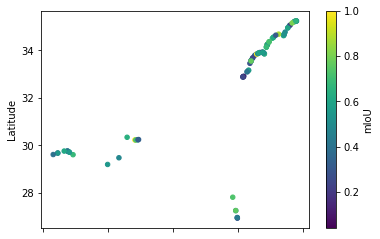

In [11]:
#plot
ax1 = doodlecsv.plot.scatter(x='Longitude',y='Latitude',c='mIoU', colormap='viridis')

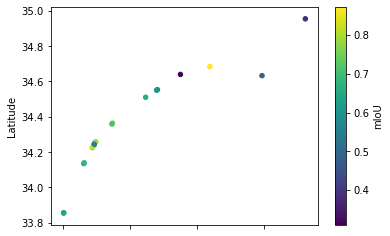

In [12]:
#florence, NC capes

flo = doodlecsv.loc[doodlecsv.storm_id == 'florence']

ax2 = flo.plot.scatter(x='Longitude',y='Latitude',c='mIoU', colormap='viridis')

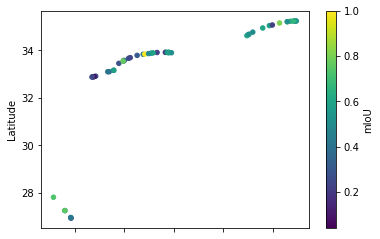

In [13]:
#Isaias, NC capes

Is = doodlecsv.loc[doodlecsv.storm_id == 'isaias']

ax2 = Is.plot.scatter(x='Longitude',y='Latitude',c='mIoU', colormap='viridis')

(-79, -75)

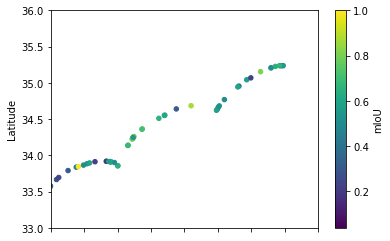

In [15]:
#Florence zoomed in onNC
ax1 = doodlecsv.plot.scatter(x='Longitude',y='Latitude',c='mIoU', colormap='viridis')
ax1.set_ylim(33,36)
ax1.set_xlim(-79,-75)

In [16]:
doodlecsv.to_csv('../data/TestingPreds.csv')

In [17]:
#To evaluate segmentation model, print test set scores:

print(doodlecsv["mDice"].mean())
print(doodlecsv["mIoU"].mean())
print(doodlecsv["IoU_c1"].mean())
print(doodlecsv["IoU_c2"].mean())
print(doodlecsv["IoU_c3"].mean())
print(doodlecsv["IoU_c4"].mean())

0.5569935189699059
0.5194074185704117
0.7624960339475256
0.5129906484387142
0.3928926227205527
0.2540779946113019
